In [2]:
import sys
print(sys.executable)
print(sys.version)

/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/bin/python
3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.0.13.3)]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C

In [4]:
# Load dataset
df = pd.read_csv("design_out.csv")

# Remove sigma_mem_y as it represents the membrane stress and is used to calculate probability of failure
# Not a model parametere which influences the model but helps to calculate the structure failure probability
df = df[['f_mem','sigma_mem','E_mem','nu_mem','sigma_edg','sigma_sup','sigma_mem_max']]
df.head() # 200 x 7

,f_mem,sigma_mem,E_mem,nu_mem,sigma_edg,sigma_sup,sigma_mem_max
0,0.268767,3220.880252,620830.965150,0.399472,325851.235578,322000.762345,4204.095289
1,0.511186,4603.969420,559505.773241,0.398297,266690.745363,366814.407254,5578.199692
2,0.316207,4020.464157,664063.602748,0.393333,350103.330214,308367.205040,4688.809620
3,0.457326,4282.802400,622714.404090,0.411230,313489.897816,327438.702828,5219.281260
4,0.261861,4097.033516,623600.545225,0.382459,334400.590712,474471.127871,4986.756515


In [5]:
# Split into features (X) and target (y)
X = df.iloc[:, :-1]  # all columns except last
y = df.iloc[:, -1]   # last column = response

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# print the features and response names 
print("Response name:", y.name)
print("Feature names:", X.columns.tolist())

Features shape: (200, 6)
Target shape: (200,)
Response name: sigma_mem_max
Feature names: ['f_mem', 'sigma_mem', 'E_mem', 'nu_mem', 'sigma_edg', 'sigma_sup']


In [6]:
# Split the data into training and testing sets 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1) SVR Model

In [7]:
# Build pipeline 
# First standardize the data, then fit SVR model
pipeline = make_pipeline(StandardScaler(), SVR())

# Define search grid
param_grid = {
    "svr__C": [0.1, 1, 10, 100, 1000],
    "svr__epsilon": [0.001, 0.01, 0.1, 0.5, 1],
    "svr__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]  # scale : (1 / (n_features * X.var())) and auto : (1 / n_features)  
}

# Run grid search with 5-fold CV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best R2 Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)




Best R2 Score: 0.9917558681931682
Best Parameters: {'svr__C': 1000, 'svr__epsilon': 0.001, 'svr__gamma': 0.01}


In [8]:
# Build final SVR model with optimal hyperparameters
svr = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=grid.best_params_['svr__C'], epsilon=grid.best_params_['svr__epsilon'], gamma=grid.best_params_['svr__gamma'])
)

# Fit on the FULL dataset (not train/test split)
svr.fit(X_train, y_train)

y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

In [9]:
# Training metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)



In [10]:
# Create datafram for errors storage with row names as model names and columns as Train and Test errors
errors_df = pd.DataFrame(
    data={
        "R2_Train": [r2_train],
        "R2_Test": [r2_test],
        "MSE_Train": [mse_train],
        "MSE_Test": [mse_test]
    },
    index=["SVR"]
)

# Save the trained model
joblib.dump(svr, "svr.pkl")

errors_df



,R2_Train,R2_Test,MSE_Train,MSE_Test
SVR,0.996683,0.997066,693.722777,1080.806261


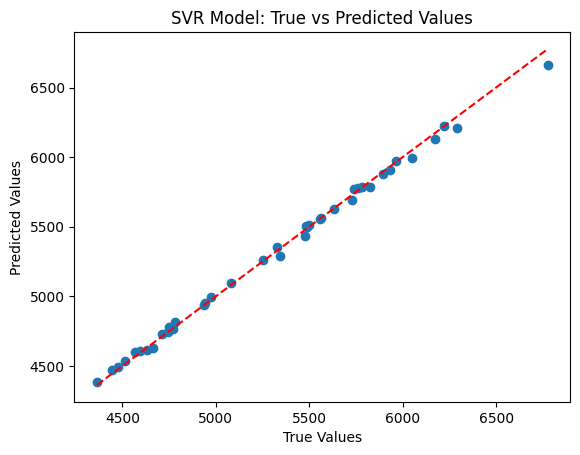

In [11]:
# Scatter plot of true vs predicted values

# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background


plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("SVR Model: True vs Predicted Values on Train Set")
plt.savefig("results/SVR_train.png", dpi=300, bbox_inches="tight")
plt.show()

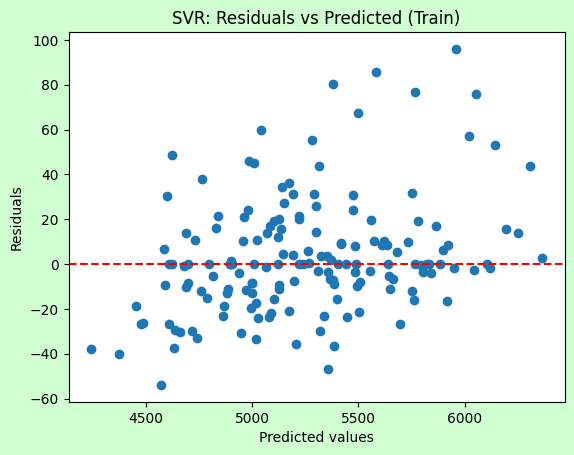

In [147]:

residuals = y_train - y_train_pred

# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

plt.scatter(y_train_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("SVR: Residuals vs Predicted (Train)")
plt.savefig("results/SVR_res_train.png", dpi=300, bbox_inches="tight")
plt.show()


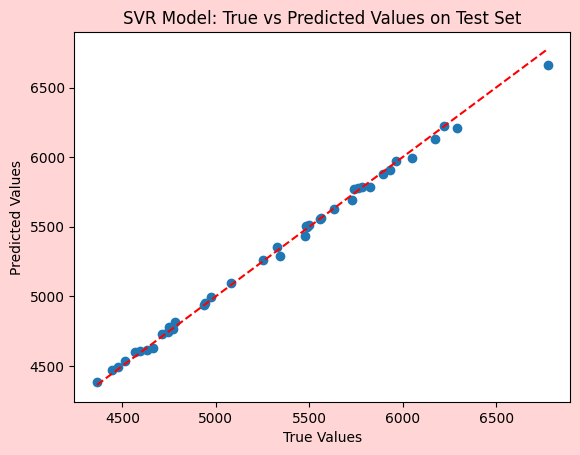

In [148]:
# Scatter plot of true vs predicted values

# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background



plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("SVR Model: True vs Predicted Values on Test Set")
plt.savefig("results/SVR_test.png", dpi=300, bbox_inches="tight")
plt.show()

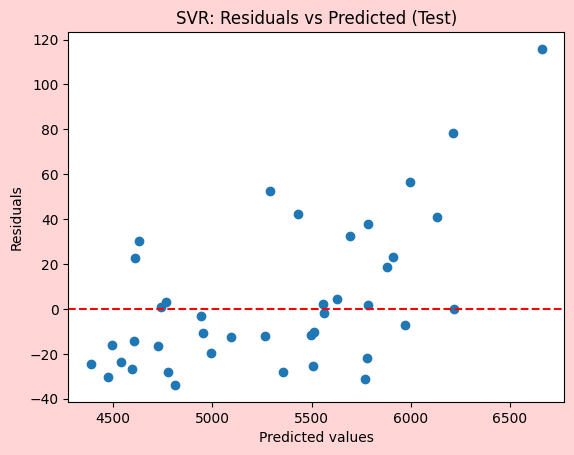

In [149]:
residuals = y_test - y_test_pred

fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

plt.scatter(y_test_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("SVR: Residuals vs Predicted (Test)")
plt.savefig("results/SVR_res_test.png", dpi=300, bbox_inches="tight")
plt.show()

## 2) Polynomial Regression 

In [12]:
# List of degrees to try
degrees = [1, 2, 3, 4, 5, 6]

best_degree = None
best_mse = float('inf')
mse_scores_per_degree = []

for degree in degrees:
    # Create pipeline: polynomial features + scaling + linear regression
    model = make_pipeline(
        PolynomialFeatures(degree=degree),
        StandardScaler(),
        LinearRegression()
    )
    
    # 5-fold cross-validation for MSE (negative because cross_val_score maximizes score)
    neg_mse_scores = cross_val_score(model, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                     scoring=make_scorer(mean_squared_error))
    mse_scores = neg_mse_scores.mean()  # Average MSE across folds
    mse_scores_per_degree.append(mse_scores)
    
    print(f"Degree {degree}: Mean 5-CV MSE = {mse_scores:.4f}")
    
    # Keep track of the best degree
    if mse_scores < best_mse:
        best_mse = mse_scores
        best_degree = degree

print(f"\nBest degree based on 5-CV MSE: {best_degree}")

# Fit final model with best degree on full training data
poly = make_pipeline(
    PolynomialFeatures(degree=best_degree),
    StandardScaler(),
    LinearRegression()
)

poly.fit(X_train, y_train)

# Predictions
y_train_pred = poly.predict(X_train)
y_test_pred = poly.predict(X_test)

# Training and test metrics

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"\nTraining R²: {r2_train:.4f}, MSE: {mse_train:.4f}")
print(f"Test R²: {r2_test:.4f}, MSE: {mse_test:.4f}")


Degree 1: Mean 5-CV MSE = 3776.0046
Degree 2: Mean 5-CV MSE = 217.9354
Degree 3: Mean 5-CV MSE = 224.4187
Degree 4: Mean 5-CV MSE = 552.8711
Degree 5: Mean 5-CV MSE = 580.8720
Degree 6: Mean 5-CV MSE = 642.9481

Best degree based on 5-CV MSE: 2

Training R²: 0.9995, MSE: 110.2521
Test R²: 0.9996, MSE: 137.5833


In [13]:
joblib.dump(poly, "poly.pkl")

# Errors from Polynomial Regression
errors_df.loc["PLY"] = [r2_train, r2_test, mse_train, mse_test]

# Display updated DataFrame
errors_df


,R2_Train,R2_Test,MSE_Train,MSE_Test
SVR,0.996683,0.997066,693.722777,1080.806261
PLY,0.999473,0.999627,110.252095,137.583329


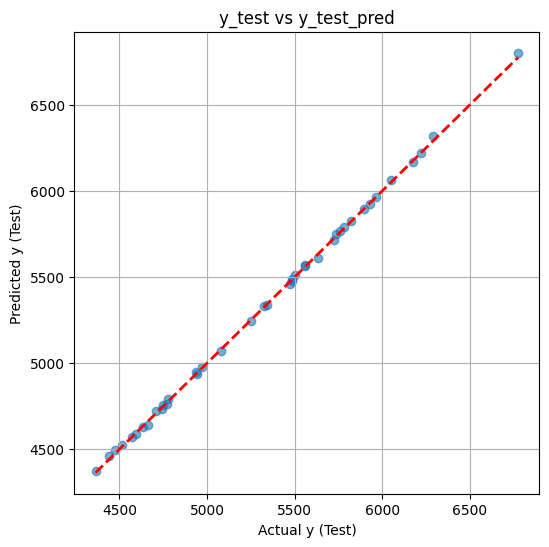

In [14]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

# Scatter plot of true vs predicted values
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("PLY Model: True vs Predicted Values on Train Set")
plt.savefig("results/PLY_train.png", dpi=300, bbox_inches="tight")
plt.show()

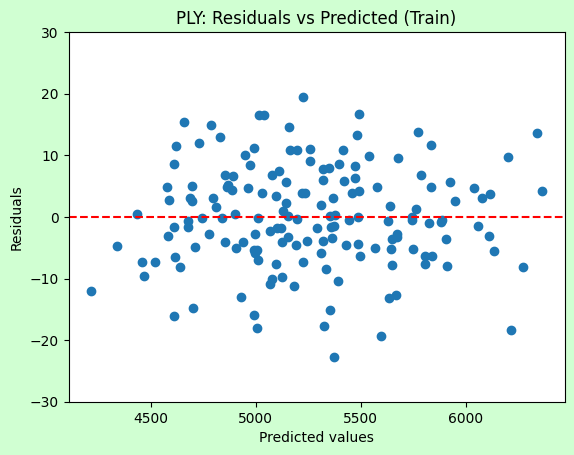

In [174]:

residuals = y_train - y_train_pred

fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

plt.scatter(y_train_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("PLY: Residuals vs Predicted (Train)")
ax.set_ylim(-30, 30)
plt.savefig("results/PLY_res_train.png", dpi=300, bbox_inches="tight")
plt.show()

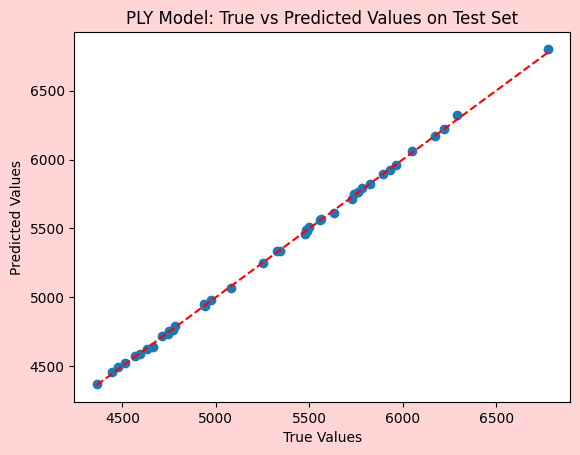

In [154]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background




# Scatter plot of true vs predicted values
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("PLY Model: True vs Predicted Values on Test Set")
plt.savefig("results/PLY_test.png", dpi=300, bbox_inches="tight")
plt.show()

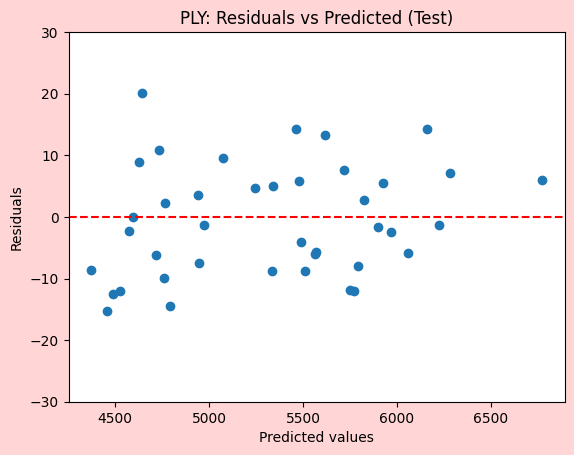

In [173]:

residuals = y_test - y_test_pred
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

plt.scatter(y_test_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("PLY: Residuals vs Predicted (Test)")
ax.set_ylim(-30, 30)
plt.savefig("results/PLY_res_test.png", dpi=300, bbox_inches="tight")
plt.show()

## 3) GPR

In [15]:

# Scale features
scaler = StandardScaler()

# Define kernel: Constant * RBF
# kernel = C(1.0, (1e-3, 1e6)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e2))
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
# kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5)




# Initialize Gaussian Process Regressor
gpr = make_pipeline(
    StandardScaler(),
    GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
)

# Fit model
gpr.fit(X_train, y_train)

# print(gpr.kernel_)
# Predictions
y_train_pred, y_train_std = gpr.predict(X_train, return_std=True)
y_test_pred, y_test_std = gpr.predict(X_test, return_std=True)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Gaussian Process Regression -> Training R²: {r2_train:.4f}, MSE: {mse_train:.4f}")
print(f"Gaussian Process Regression -> Test R²: {r2_test:.4f}, MSE: {mse_test:.4f}")
print(gpr.named_steps['gaussianprocessregressor'].kernel_)


Gaussian Process Regression -> Training R²: 0.9997, MSE: 67.6425
Gaussian Process Regression -> Test R²: 0.9998, MSE: 80.2773
5.44**2 * RBF(length_scale=13.6) + WhiteKernel(noise_level=0.001)


/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [16]:
joblib.dump(gpr, "gpr.pkl")

# Errors from Gaussian Regression
errors_df.loc["GPR"] = [r2_train, r2_test, mse_train, mse_test]

# Display updated DataFrame
errors_df





,R2_Train,R2_Test,MSE_Train,MSE_Test
SVR,0.996683,0.997066,693.722777,1080.806261
PLY,0.999473,0.999627,110.252095,137.583329
GPR,0.999677,0.999782,67.642533,80.277325


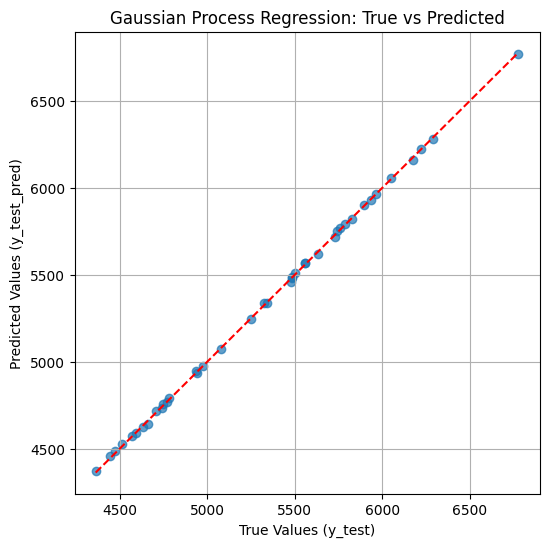

In [17]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

# Scatter plot of true vs predicted values
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("GP Model: True vs Predicted Values on Train Set")
plt.savefig("results/GP_train.png", dpi=300, bbox_inches="tight")
plt.show()

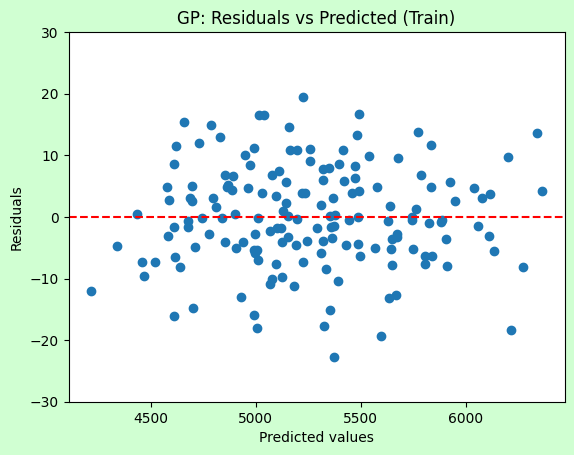

In [172]:
residuals = y_train - y_train_pred

fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

plt.scatter(y_train_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("GP: Residuals vs Predicted (Train)")
ax.set_ylim(-30, 30)
plt.savefig("results/GP_res_train.png", dpi=300, bbox_inches="tight")
plt.show()

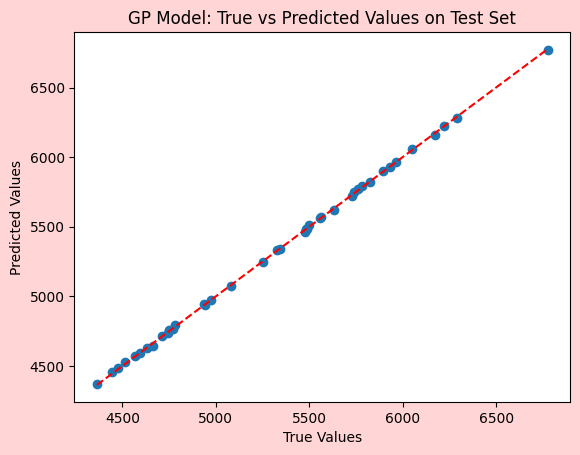

In [ ]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

# Scatter plot of true vs predicted values
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("GP Model: True vs Predicted Values on Test Set")
plt.savefig("results/GP_test.png", dpi=300, bbox_inches="tight")
plt.show()

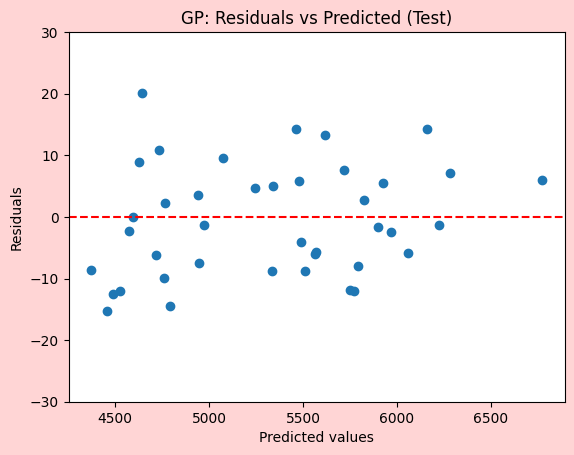

In [171]:
residuals = y_test - y_test_pred

fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

plt.scatter(y_test_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("GP: Residuals vs Predicted (Test)")
ax.set_ylim(-30, 30)
plt.savefig("results/GP_res_test.png", dpi=300, bbox_inches="tight")
plt.show()

In [162]:
# Select only MSE columns
mse_df = errors_df[["MSE_Train", "MSE_Test"]]
mse_df

,MSE_Train,MSE_Test
SVR,693.721558,1080.812744
PLY,110.252095,137.583329
GPR,67.642365,80.277429


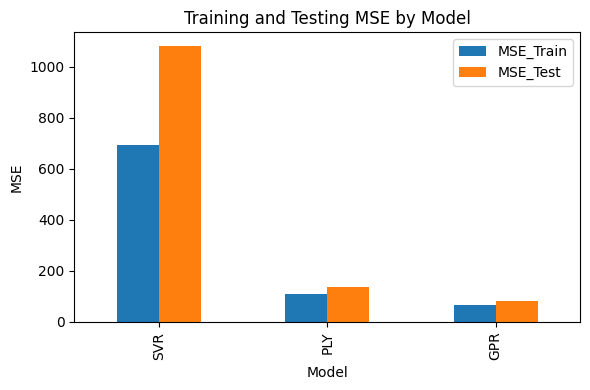

In [163]:
# Plot grouped bar chart
ax = mse_df.plot(kind="bar", figsize=(6, 4))
ax.set_xlabel("Model")
ax.set_ylabel("MSE")
ax.set_title("Training and Testing MSE by Model")
plt.tight_layout()
plt.savefig("results/mse_bar_chart.png", dpi=300, bbox_inches="tight")
plt.show()

## 4) Uncertainty Propagation

In [18]:
import numpy as np
import pandas as pd

# Constants
N = 10000 #sample size
gamma = 0.5772156649  # Euler-Mascheroni constant

def get_lognormal_params(mean, sd):
    var = sd**2
    sigma = np.sqrt(np.log(1 + var / mean**2))
    mu = np.log(mean) - 0.5 * sigma**2
    return mu, sigma

def get_gumbel_params(mean, sd):
    scale = sd * np.sqrt(6) / np.pi
    loc = mean - scale * gamma
    return loc, scale

def get_uniform_params(mean, sd):
    # SD = (high - low) / sqrt(12)
    # Mean = (high + low) / 2
    delta = sd * np.sqrt(3)
    low = mean - delta
    high = mean + delta
    return low, high

# Generate data
data = {}

# f_mem: Gumbel
loc, scale = get_gumbel_params(0.4, 0.12)
data['f_mem'] = np.random.gumbel(loc, scale, N)

# Lognormal variables
lognorm_vars = {
    'sigma_mem_y': (11000, 1650),
    'sigma_mem': (4000, 800),
    'E_mem': (600000, 90000),
    'sigma_edg': (353677.6513, 70735.53026),
    'sigma_sup': (400834.6715, 80166.9343)
}

for name, (m, s) in lognorm_vars.items():
    mu, sigma = get_lognormal_params(m, s)
    data[name] = np.random.lognormal(mu, sigma, N)

# nu_mem: Uniform
low, high = get_uniform_params(0.4, 0.01154700538)
data['nu_mem'] = np.random.uniform(low, high, N)

try:
    samples_df = pd.read_csv('sample_points.csv')
except FileNotFoundError:
    # Create DataFrame
    samples_df = pd.DataFrame(data)
    # Save to CSV
    samples_df.to_csv('sample_points.csv', index=False)

# Summary statistics for verification
summary = samples_df.agg(['mean', 'std']).T
summary['variance'] = summary['std']**2
print(summary)

                      mean           std      variance
f_mem             0.400017      0.122363  1.497269e-02
sigma_mem_y   11006.915552   1647.463875  2.714137e+06
sigma_mem      4004.092529    800.288791  6.404621e+05
E_mem        599744.298013  91200.170008  8.317471e+09
sigma_edg    354031.078148  70842.419793  5.018648e+09
sigma_sup    400039.964252  81926.101818  6.711886e+09
nu_mem            0.400013      0.011426  1.305524e-04


In [19]:
samples_df = samples_df[['f_mem','sigma_mem','E_mem','nu_mem','sigma_edg','sigma_sup']]
samples_df.head()
samples = samples_df.values

In [20]:
poly.predict(samples[0:10])

/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([5490.28901174, 5601.69053691, 4330.12129635, 6036.37014966,
       6903.1560084 , 4497.79035799, 5344.15778607, 4686.5053377 ,
       5965.08856618, 5568.03075001])

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def uncertainty(model, samples, model_name="Surrogate Model", unit="Units"):
    """
    Performs uncertainty quantification on a model using provided samples.
    
    Parameters:
    model: Trained sklearn-compatible model (SVR, GP, etc.)
    samples: (N, features) array of Monte Carlo samples
    model_name: String for plot titles
    unit: String for axis labels (e.g., 'MPa' or 'kN')
    """
    # 1. Generate Predictions
    predictions = model.predict(samples).flatten()
    
    # 2. Calculate Statistics
    mu = np.mean(predictions)
    sigma = np.std(predictions)
    cv = (sigma / mu) * 100 if mu != 0 else 0  # Coefficient of Variation
    
    # 3. Create Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    # --- Plot 1: Histogram & KDE ---
    sns.histplot(predictions, kde=True, ax=ax1, color='teal', bins=40, stat="density", alpha=0.4)
    ax1.axvline(mu, color='red', linestyle='--', label=f'Mean: {mu:.2f}')
    ax1.axvline(mu - 2*sigma, color='orange', linestyle=':', label=f'±2σ (95% CI)')
    ax1.axvline(mu + 2*sigma, color='orange', linestyle=':')
    
    ax1.set_title(f"Uncertainty Distribution: {model_name}")
    ax1.set_xlabel(f"Predicted Output ({unit})")
    ax1.set_xlim(3000, 9000)
    ax1.set_ylim(0, 0.001)
    ax1.legend()
    
    # --- Plot 2: Box & Whisker (Outlier Analysis) ---
    sns.boxplot(y=predictions, ax=ax2, color='lightblue', width=0.4)
    ax2.set_title("Statistical Spread")
    ax2.set_ylabel(f"Output ({unit})")
    
    plt.tight_layout()
    plt.show()
    
    # 4. Return Summary Report
    return {
        "Mean": mu,
        "Std_Dev": sigma,
        "COV_Percent": cv,
        "Min": np.min(predictions),
        "Max": np.max(predictions)
    }

/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


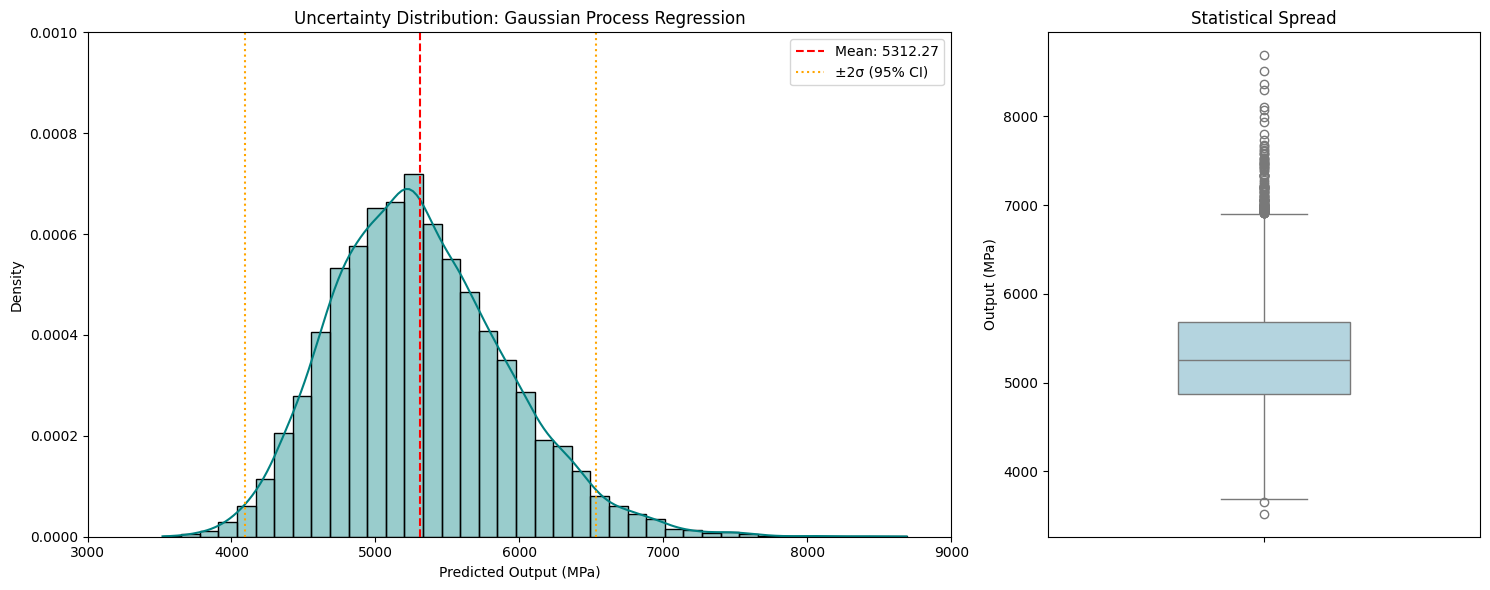

{'Mean': np.float64(5312.26547248093),
 'Std_Dev': np.float64(609.9889555743124),
 'COV_Percent': np.float64(11.482651963352197),
 'Min': np.float64(3520.994373772174),
 'Max': np.float64(8689.611146657535)}

In [22]:
uncertainty(gpr, samples, model_name="Gaussian Process Regression", unit="MPa")

/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


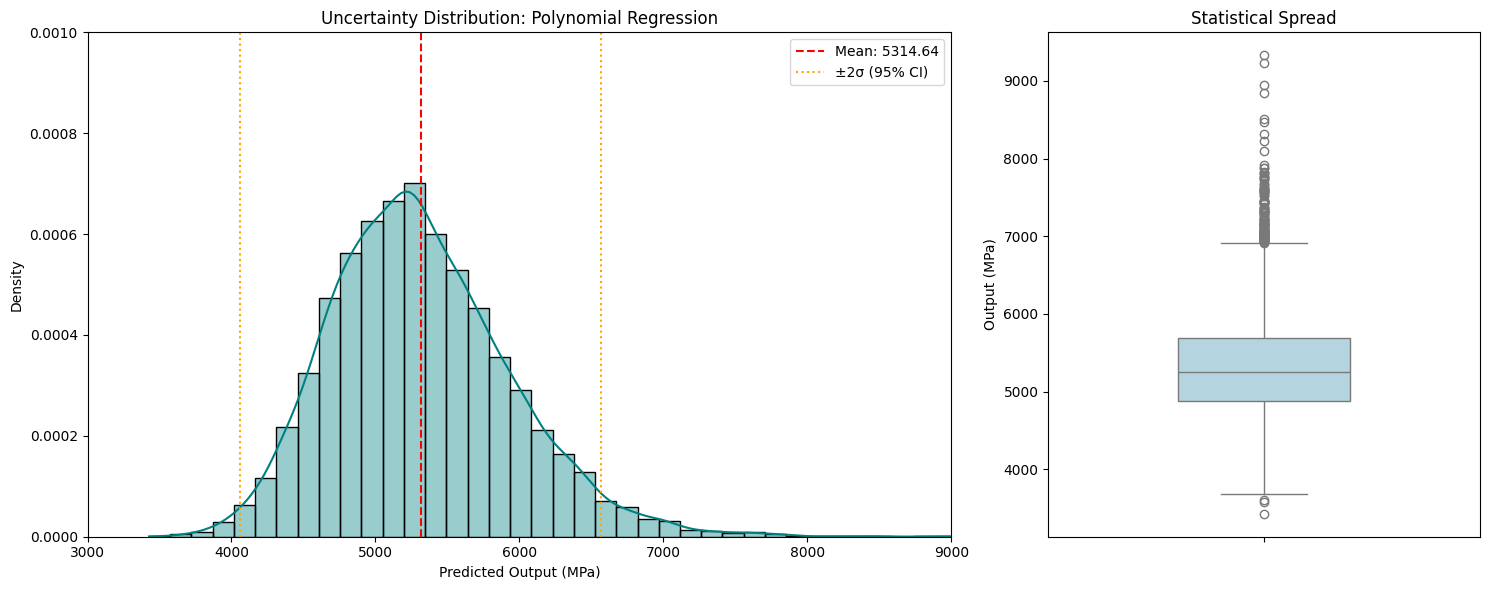

{'Mean': np.float64(5314.635055261468),
 'Std_Dev': np.float64(626.7527882294055),
 'COV_Percent': np.float64(11.79296003794132),
 'Min': np.float64(3427.106456259695),
 'Max': np.float64(9329.47237006467)}

In [23]:
uncertainty(poly, samples, model_name="Polynomial Regression", unit="MPa")

c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


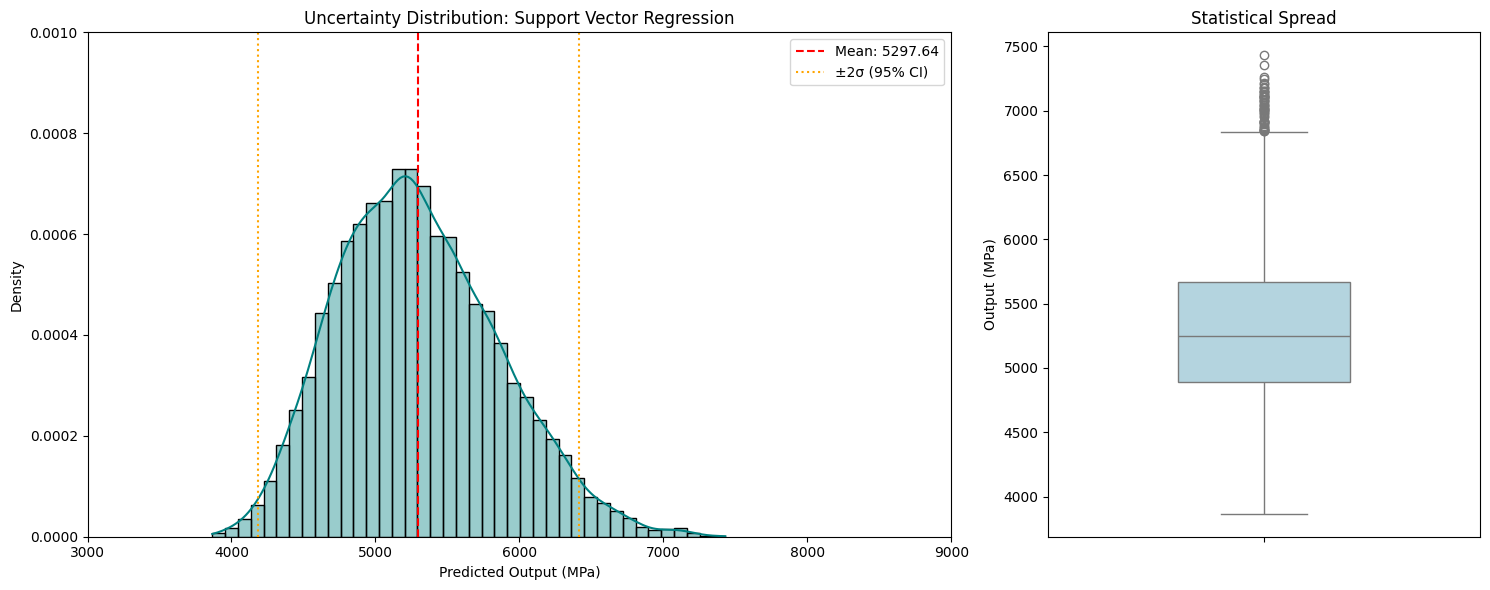

{'Mean': np.float64(5297.643306680416),
 'Std_Dev': np.float64(558.1346876187678),
 'COV_Percent': np.float64(10.535527881141993),
 'Min': np.float64(3866.335635316496),
 'Max': np.float64(7430.860165990809)}

In [24]:
uncertainty(svr, samples, model_name="Support Vector Regression", unit="MPa")

### Results

In [25]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define the problem based on your features
# Using the bounds observed in your dataset or defined distributions
problem = {
    'num_vars': 6,
    'names': ['f_mem', 'sigma_mem', 'E_mem', 'nu_mem', 'sigma_edg', 'sigma_sup'],
    'bounds': [
        [0.1, 0.7],          # f_mem
        [3000, 5000],        # sigma_mem
        [500000, 700000],    # E_mem
        [0.35, 0.45],        # nu_mem
        [250000, 450000],    # sigma_edg
        [300000, 500000]     # sigma_sup
    ]
}

# 2. Generate samples for Sobol analysis
# N should be a power of 2 for better results
param_values = saltelli.sample(problem, 1024)

# 3. Run the model (e.g., using your GPR model)
# Note: Ensure the model is loaded or defined as 'gpr' in your environment
y = gpr.predict(param_values)

# 4. Perform Sobol analysis
Si = sobol.analyze(problem, y)

# 5. Convert to a DataFrame for easier handling
sobol_df = pd.DataFrame({
    'Parameter': problem['names'],
    'First_Order (S1)': Si['S1'],      # Contribution of each variable alone
    'Total_Order (ST)': Si['ST']       # Contribution including interactions
})

print(sobol_df)

/var/folders/0g/m0pt1c8j5c5f8sj0476m6j4h0000gn/T/ipykernel_80590/2347411504.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)
/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


   Parameter  First_Order (S1)  Total_Order (ST)
0      f_mem          0.714319          0.715555
1  sigma_mem          0.130423          0.136280
2      E_mem          0.000365          0.000610
3     nu_mem          0.000085          0.000363
4  sigma_edg          0.081116          0.086426
5  sigma_sup          0.065797          0.067179


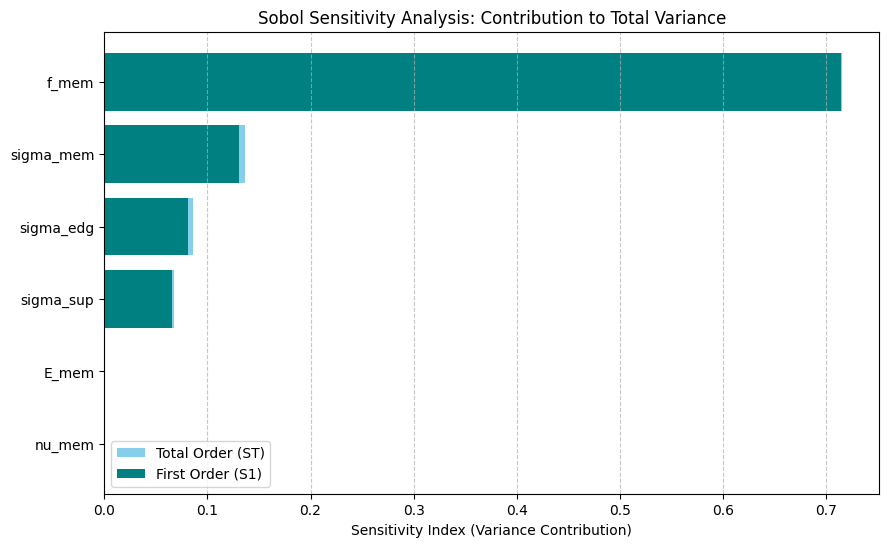

In [26]:
# Sort values for better visualization
sobol_df = sobol_df.sort_values(by='Total_Order (ST)', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(sobol_df['Parameter'], sobol_df['Total_Order (ST)'], color='skyblue', label='Total Order (ST)')
plt.barh(sobol_df['Parameter'], sobol_df['First_Order (S1)'], color='teal', label='First Order (S1)')

plt.xlabel('Sensitivity Index (Variance Contribution)')
plt.title('Sobol Sensitivity Analysis: Contribution to Total Variance')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()